In [3]:
from survival import sample_survival_poisson, evaluate_test_stats
import numpy as np
import pandas as pd

In [28]:
import numpy as np
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
konp_test = importr('KONPsurv')

def konp_testR(times, status, groups):
    res = konp_test.konp_test(times, status, groups, n_perm=1)
    return dict(chisq_test_stat=res[3][0], lr_test_stat=res[4][0],cauchy_test_stat=res[5][0])


def time2event(times, num_events, num_censored, initial_at_risk):
    """
    Convert number of events and censored to time-to-event data.

    The number of events and censored at each time point is converted to a list of event times and event status.
    All events are assumed to occur at the same time as the time point.
    Events are coded as 1 and censored as 0.
    All at risk at the last time point are assumed to be censored.
    """

    assert len(times) == len(num_events) == len(num_censored) 
    assert initial_at_risk >= np.sum(num_events) + np.sum(num_censored)

    num_censored[-1] = num_censored[-1] + initial_at_risk - np.sum(num_events) - np.sum(num_censored)
    r_times = []
    r_status = []
    for i,t in enumerate(times):
        ne = num_events[i]
        nc = num_censored[i]
        r_times += ([t] * (ne + nc))
        r_status += ([1] * ne + [0] * nc)
    
    return r_times, r_status

def evaluate_test_stats_konp(Ot1, Ot2, Ct1, Ct2, N1, N2):
    times1, status1 = time2event(np.arange(1,T+1), Ot1, Ct1, N1)
    times2, status2 = time2event(np.arange(1,T+1), Ot2, Ct2, N2)
    times = FloatVector(times1 + times2)
    status = FloatVector(status1 + status2)
    groups = FloatVector([0] * len(times1) + [1] * len(times2))
    return konp_testR(times, status, groups)


In [34]:
T = 100
N2 = N1 = 1000
lam0 = np.ones(T)/T
beta = .7
eps = .1
r = 1

Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam0, eps, r)
Ot1 = -np.diff(Nt1).astype(int)
Ot2 = -np.diff(Nt2).astype(int)
Ct1 = np.diff(Nt1).astype(int) + Ot1
Ct2 = np.diff(Nt1).astype(int) + Ot1

evaluate_test_stats_konp(Ot1, Ot2, Ct1, Ct2, N1, N2)

{'chisq_test_stat': 4.146427783502213,
 'lr_test_stat': 4.152684664280177,
 'cauchy_test_stat': 48.473458785235884}

In [24]:
konp_testR(times, status, groups)

{'chisq_test_stat': 10.322213356146667,
 'lr_test_stat': 10.348492614411335,
 'cauchy_test_stat': 209311.88963528138}

In [ ]:

times = FloatVector(np.concatenate([Nt1, Nt2]))
status = FloatVector(np.concatenate([np.ones(N1), np.zeros(N2)]))
groups = FloatVector(np.concatenate([np.ones(N1), np.zeros(N2)]))
konp_testR(times, status, groups)

In [ ]:
from lifelines.statistics import logrank_test

def logrank_lifeline_survival_table(df_table, **kwrgs):
    """
    Apply the logrank test from lifeline to survival table.
    To do so, we first need to convert the table to time-to-event representation
    by duplicating entries of removed subjects (observed or censored)
    """

    def table2time(df):
        df_obs = df.loc[df.index.repeat(df['observed'])]
        df_cen = df.loc[df.index.repeat(df['censored'])]

        df_obs['event'] = (df_obs['observed'] > 0) + 0.0
        df_cen['event'] = 0

        return pd.concat([df_obs, df_cen], axis=0).filter(['event'])

    dfg0 = df_table.filter(like=r':0')
    dfg1 = df_table.filter(like=r':1')

    dft0 = table2time(dfg0.rename(columns={'observed:0': 'observed', 'censored:0': 'censored'}))
    dft1 = table2time(dfg1.rename(columns={'observed:1': 'observed', 'censored:1': 'censored'}))

    return logrank_test(dft0.index, dft1.index,
                        event_observed_A=dft0['event'], event_observed_B=dft1['event'],
                        **kwrgs)


In [37]:
N1

1000

In [ ]:
N1 = Nt1[0]
N2 = Nt2[0]
Nt1 = np.concatenate([Nt1, [Nt1[-1]-Ot1[-1]]], axis=0)
Nt2 = np.concatenate([Nt2, [Nt2[-1]-Ot2[-1]]], axis=0)
Ct1 = (-np.diff(Nt1) - Ot1).astype(int)
Ct2 = (-np.diff(Nt2) - Ot2).astype(int)

assert np.all(Ct1 >= 0)
assert np.all(Ct2 >= 0)

if no_censoring:
    assert np.abs(Ct1).sum() == 0
    assert np.abs(Ct2).sum() == 0

res_ll = evaluate_test_stats_lifeline(Ot1, Ot2, Ct1, Ct2, N1, N2)
res_konp = evaluate_test_stats_konp(Ot1, Ot2, Ct1, Ct2, N1, N2)

## Synthetic experiment

In [12]:
STBL = True
T = 100
N2 = N1 = 1000
lam0 = 1
beta = .7
r = 1

eps = T ** (-beta)
lam = lam0 * np.ones(T) / T

nMonte = 100
results = {}
for itr in range(nMonte):
    Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam, eps, r)
    Ot1 = -np.diff(Nt1).astype(int)
    Ot2 = -np.diff(Nt2).astype(int)
    res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2,
                                randomized=True, alternative='greater', stbl=STBL)
    results[itr] = res

KeyboardInterrupt: 

##### Null data

In [21]:
nMonte = 10000
results0 = {}
for itr in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam, 0, 0)
    Ot1 = -np.diff(Nt1).astype(int)
    Ot2 = -np.diff(Nt2).astype(int)
    res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2, alternative='two-sided', stbl=STBL)
    results0[itr] = res

pd.DataFrame(results0).T.to_csv(f"results/synthetic_null_data_T{T}_N{N1}_nMonte{nMonte}.csv")

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [23:19<00:00,  7.15it/s]  


In [1]:
from rpy2.robjects.packages import importr
konp_test = importr('KONPsurv')

def konp_testR(times, status, groups):
    """
    Apply the KONP test from R to survival table. (https://cran.r-project.org/web/packages/KONPsurv/)

    """
    res = konp_test.konp_test(times, status, groups, n_perm=1)
    return dict(chisq_test_stat=res[3][0], lr_test_stat=res[4][0],cauchy_test_stat=res[5][0])


In [43]:
df1 = pd.DataFrame(results).T
df0 = pd.DataFrame(results0).T

lo_stats = df1.columns

alpha = 0.05
crit_vals = {}
no_dicoveries = {}
rate_dicoveries = {}
for st in lo_stats:
    crit_vals[st] = df0[st].quantile(1 - alpha)
    no_dicoveries[st] = np.sum(df1[st] > crit_vals[st])
    rate_dicoveries[st] = np.mean(df1[st] > crit_vals[st])


In [34]:
pd.DataFrame.from_dict(no_dicoveries, orient='index').to_latex()

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_49046/2640714225.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame.from_dict(no_dicoveries, orient='index').to_latex()


'\\begin{tabular}{lr}\n\\toprule\n{} &   0 \\\\\n\\midrule\nlog\\_rank\\_greater                       &  28 \\\\\nlog\\_rank\\_pval\\_greater                  &   0 \\\\\nhc\\_greater                             &  57 \\\\\nfisher\\_greater                         &  38 \\\\\nmin\\_p\\_greater                          &  48 \\\\\nberk\\_jones\\_greater                     &   4 \\\\\nlog\\_rank\\_less                          &  28 \\\\\nlog\\_rank\\_pval\\_less                     &  28 \\\\\nhc\\_less                                &   6 \\\\\nfisher\\_less                            &   3 \\\\\nmin\\_p\\_less                             &   3 \\\\\nberk\\_jones\\_less                        &   6 \\\\\nlogrank\\_lifelines\\_None                 &   4 \\\\\nlogrank\\_lifelines\\_wilcoxon             &   6 \\\\\nlogrank\\_lifelines\\_tarone-ware          &   3 \\\\\nlogrank\\_lifelines\\_peto                 &   6 \\\\\nlogrank\\_lifelines\\_fleming-harrington55 &   3 \\\\\nlogrank\\

In [ ]:
T = 60
N1 = 1500
N2 = 1500
eps = 0.1
lam_bar = .25
lam0 = lam_bar / T * np.ones(T)
lamc = 0.1
r = 1
Nt1, Nt2, Ot1, Ot2  = sample_survival_poisson_censorship(T, N1, N2, lam0, lamc, eps, r)
Ct1 = np.zeros_like(Nt1)
Ct2 = np.zeros_like(Nt2)
Ct1[:-1] = -np.diff(Nt1) - Ot1[:-1]
Ct2[:-1] = -np.diff(Nt2) - Ot2[:-1]


## Check exponential decay

  9%|▉         | 9/100 [00:03<00:32,  2.78it/s]


KeyboardInterrupt: 

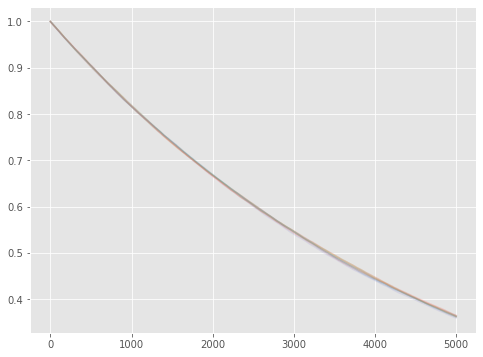

In [5]:
# this script shows that if Ny(0) = y_0,  y_0/T --> \infty and T -> \infty, then  sup_t T^\beta | e^{\lambda t} Ny(t)/Ny(0) - 1 | -> 0

T = 5000
N1 = N2 = 5 * T

beta = .6         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
r = 1
lam0 = np.ones(T) / T 
tt = np.arange(1, T+1)

nMonte = 100

NNt1 = np.zeros((nMonte, T))
NNt2 = np.zeros((nMonte, T))

plt.figure()
for i in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam0, eps, r)
    NNt1[i] = Nt1[1:]
    NNt2[i] = Nt2[1:]
    N0 = 2 * Nt1 * Nt2 / (Nt1 + Nt2) / N1
    plt.plot(N0, alpha=.2)
plt.plot(np.exp(-tt * lam0),'--')
plt.plot(Nt2 / N2, 'r')
plt.title("$N_y(t)/y_0$")
plt.show()

plt.plot(T ** beta * ((Nt2[1:] / N2 * np.exp(tt * lam0)) - 1) )
plt.title(r"$T^{\beta}(\exp(t \lambda) \cdot N_y(t)/y_0 - 1) $")
plt.show()

Text(0.5, 1.0, 'Check variance')

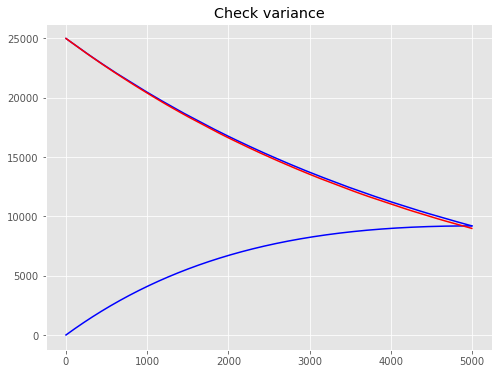

In [80]:
plt.plot(NNt1.var(0), 'b')
plt.plot(tt*lam0*(1-lam0)**(tt-1) * N1, '--b')
plt.plot(NNt2.var(0), 'r')
plt.title("Check variance")

Text(0.5, 1.0, 'Check mean')

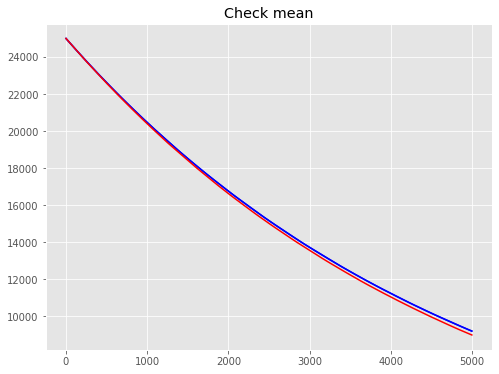

In [83]:
plt.plot(NNt1.mean(0), 'b')
plt.plot((1-lam0)**tt*N1, 'b')
plt.plot(NNt2.mean(0), 'r')
plt.title("Check mean")

## Check Log-rank test

In [193]:
T = 5000
N1 = N2 = int(T * np.log(T) ** 2)

beta = .6         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
r = 0.1
lam0 = np.ones(T) / T 

Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam0, eps, r)

nMonte = 100

AA = np.zeros(nMonte)
BB = np.zeros(nMonte)
BBapp = np.zeros(nMonte)
zz = np.zeros(nMonte)

for i in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_poisson(T, N1, N2, lam0, eps, r)
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)

    Nt = Nt2 + Nt1
    e0 = Nt2[:-1] * (Ot1 + Ot2) / Nt[:-1]
    var0 = e0 * ((Nt[:-1] - (Ot1 + Ot2)) / Nt[:-1]) * (Nt1[:-1] / (Nt[:-1] - 1))
    AA[i] = np.sum(Ot2 - e0)
    BB[i] = np.sum(var0)
    BBapp[i] = np.sum(e0 / 2)
    z = AA[i] / np.sqrt(BB[i])
    zz[i] = z


100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


\begin{align*}
    E_t & := \frac{N_y(t-1)}{N(t-1)} O(t),\\
    V_t & := E_t \frac{N_x(t-1)}{N(t-1)-1}  \left(1 - \frac{E_t}{N_y(t-1)} \right). 
\end{align*}

## Check P-values

### Current issue (28/7/2022):
- Empitrical and variance-stabilized Multinomial P-values agree with theoretical log-chisquared approximation in the balanced case
- Can try and easily proove the balanced case by saying that hypergeometric p-values behaves like the binomial P-values in view of the convergence rate of $N_\star(t)$ to $N_\star(0)e^{-\bar{\lambda}t}$
- In the inbalanced case, preivous calculation shows that variance-stabilized log-chisquared parameters are independent of $\kappa$, but that implies that these P-values are better than binomial / hypergeometric. 
- Possible outlets:
 - Binomial P-values are also independent of $\kappa$
 - The dependency of binomial P-values in $\kappa$ makes them smaller hence HC is more powerful
 - There is a mistake in the variance-stabilization assumptions
- To do:
 1. Verify variance stabilization by simulation
 2. Redo binomial P-values



In [6]:
def sample_perturbed(T, N1, N2, lam0, r):
    lam1 = lam0  # `base` Poisson rates (does not have to be fixed)
    lam2 = lam1
    nt = 2 * N1 * N2 / (N1 + N2)
    mu = np.sqrt(r / 2 * np.log(T))
    lam2 = (np.sqrt(mu / nt) + np.sqrt(lam1)) ** 2  # perturbed Poisson rates

    O1 = poisson.rvs(N1 * lam1)
    O2 = poisson.rvs(N2 * lam2)
    return N1 - O1, N2 - O2


def sample_perturbed2(T, N1, N2, lam0, r):
    lam1 = lam0  # `base` Poisson rates (does not have to be fixed)
    lam2 = lam1
    nt = 2 * N1 * N2 / (N1 + N2)
    mu = np.sqrt(r / 2 * np.log(T))
    lam2 = (np.sqrt(mu / nt) + np.sqrt(lam1)) ** 2  # perturbed Poisson rates

    O1 = poisson.rvs(N1 * lam1)
    O2 = poisson.rvs(N2 * lam2)
    return O1, O2


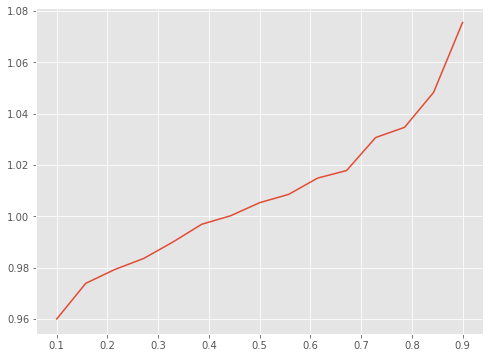

In [7]:
# Here we verify that the variance-stabilized poisson is independent of kappa
kk = np.linspace(0.1, .9, 15)

acc = []
for kappa in kk:
    T = 100000
    n = 20 * T # n/T -> infty
    r = .3
    n1 =n * (1 - kappa)
    n2 = n * kappa
    n0 = 2 * n1 * n2 / (n1 + n2)
    delta = r * np.log(T) / n0 / 2

    lam0 = 2 / T # lam0 * T < const
    lam1 = (np.sqrt(lam0) + np.sqrt(delta)) ** 2

    X = poisson.rvs(lam0 * n1, size = T)
    Y = poisson.rvs(lam1 * n2, size = T)

    W = np.sqrt(4 * (1 - kappa) * Y) - np.sqrt(4 * kappa * X)

    #print("STD = ",)
    std = np.std(W)
    #print("MEAN = ", np.mean(W) / np.sqrt(r) / np.sqrt(np.log(T)))
    #plt.hist(W)
    #a = kappa * (1-kappa)
    mean = np.mean(W) / np.sqrt(r) / np.sqrt(np.log(T))
    acc += [mean]

plt.plot(kk, acc)
#plt.plot(kk, np.sqrt(kk * (1 - kk)))
plt.show()

### Verify the lower bound on $\pi(x,y;n_x,n_y)$ required for the converse

\begin{align*}
& \inf_{x \geq \lambda - \sqrt{a(T) \lambda}} T^q \pi(x, \tilde{y};n_x,n_y) = T^{q} \pi(x^*,\tilde{y};n_x,y_) \\
& \qquad  \geq T^q e^{o(1)} 2^{-(x^*+\tilde{y})-1} \frac{(1+o(1))}{\sqrt{2 \pi}} \sqrt{\frac{x^*+\tilde{y}}{x^*\tilde{y}}} \left(1+\frac{\tilde{y}}{x^*} \right)^{x^*} \left(1+\frac{x^*}{\tilde{y}} \right)^{\tilde{y}}.
\end{align*}

Where 
- $x^* = \lambda - \sqrt{a(T) \lambda}$ 
- $\tilde{y} := \tilde{y}(T,q) =\left( \sqrt{x} + \sqrt{q \log(T) - a(T) } \right)$
- and $a(T)$ satisfies: $a(T) \lambda(T) \geq \log^2(T)$ and $a(T)/\log(T) \to 0$


In [75]:
T = 100000000
q = 0.5
lam0 = 4/T
Nx = T * np.log(T)

lam = Nx*lam0

a =  q * (np.log(T)**2/(lam) + np.sqrt(np.log(T)))

xs = lam - np.sqrt(a * lam)
ys = (np.sqrt(xs) + np.sqrt(q * np.log(T) - a) ) ** 2


q * np.log(T)+ (-xs - ys) * np.log(2) + np.log( np.sqrt((xs + ys) / (xs * ys) ) ) + xs * np.log( (1 + ys/xs)) + ys * np.log( (1 + xs/ys) )

2.9240936156649724

In [46]:
from scipy.stats import hypergeom
def hypergeom_test(k, M, n, N, alternative='greater', randomize=False):
    """
    Exact hypergeometric test
    
    Args:
    -----
    :k:    number of observed Type I objects
    :M:    total number of object
    :n:    total number of Type I objects
    :N:    number of draws
    :randomize:   whether to do a randomized test
    :alternative: type of alternative to consider. Options are: 
                  'greater', 'less', 'two-sided'
    
    Returns:
        Test's P-value
    """

    if randomize:
        U = uniform.rvs(size=len(k))
    else:
        U = 0

    if alternative == 'greater':
        return hypergeom.sf(k - 1, M, n, N) - U * hypergeom.pmf(k, M, n, N)
        # sf is 1-cdf, so Pr(X >= k) = Pr(X>k-1)

In [66]:
import math

nx = 1000
ny = 1000
ys = 200
xs = 200

N = int(xs) + int(ys)
n = ny
M = nx + ny
k = int(ys)
hypergeom.pmf(ys, M, n, N)

0.0445738417491552

In [67]:
math.comb(N, k) * math.comb(M - N, n-k) / math.comb(M, n)

0.04457384174915524

$a(T) = \log^2(T)/ (\bar{\lambda}n_x) + \sqrt{\log(T)}$

In [404]:
def binom_test_two_sided(x, n, p, randomize=False):
    """
    :x:   number of observed successes
    :n:   number of trails
    :p:   probability of success
    :randomize:   whether to do a randomized test or not
                  a randomized test returns a P-value that
                  is uniformly distributed if x ~ Bin(n,p)

    Returns:
        :pval:  if randomize=False, pval=Prob( |Bin(n,p) - np| >= |x-np| )
                if randomize=True, pval is a random number such that
            Prob(
            |Bin(n,p) - np| >= |InBinCDF(pval|n, p) - n p|
            ) ~ U(0,1)

    Note: The expression pval=Prob( |Bin(n,p) - np| >= |x-np| ) is not accurate
        when p is close to either 0 or 1. For such cases, it is better to use
        scipy.python.binom_test which is essentially the R function binom_test

    """

    x_low = n * p - np.abs(x - n * p)
    x_high = n * p + np.abs(x - n * p)

    n = n.astype(int)
    p_up = binom.cdf(x_low, n, p) + binom.sf(x_high - 1, n, p)

    if randomize:
        p_down = binom.cdf(x_low - 1, n, p) + binom.sf(x_high, n, p)
        U = np.random.rand(len(x))  # uniform random variable
        prob = (n != 0) * np.minimum(p_down + (p_up - p_down) * U, 1) + U * (n == 0)
    else:
        prob = np.minimum(p_up, 1)
    return prob


def binom_test(x, n, p, alternative='two-sided', randomize=False):
    """
    :x:   number of observed successes
    :n:   number of trails
    :p:   probability of success

    Returns:
    --------
    Prob(Bin(n,p) >= x) ('greater')
    or Prob(Bin(n,p) <= x) ('less')

    Note: for small values of Prob there are differences
    fron scipy.python.binom_test.
    """
    n = n.astype(int)
    if randomize:
        U = np.random.rand(len(x))
    else:
        U = 0
    if alternative == 'greater':
        return binom.sf(x, n, p) + U * binom.pmf(x, n, p)
    if alternative == 'less':
        return binom.cdf(x, n, p) - U * binom.pmf(x, n, p)
    if alternative == 'two-sided':
        x_low = n * p - np.abs(x - n * p)
        x_high = n * p + np.abs(x - n * p)
        U2 = np.random.rand(len(x))
        
        p_up = binom.cdf(x_low, n, p) + binom.sf(x_high-1, n, p)

        p_down = binom.cdf(x_low - 1, n, p) + binom.sf(x_high, n, p)

        prob = (n != 0) * np.minimum(p_down + (p_up - p_down) * U, 1) + U * (n == 0)

        return prob
        


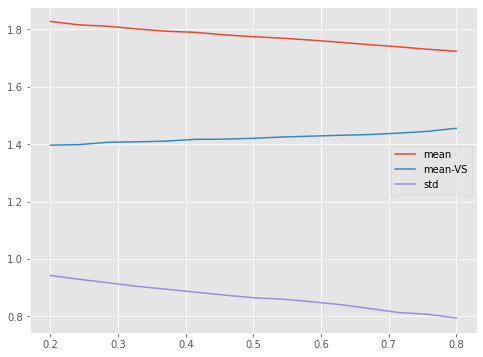

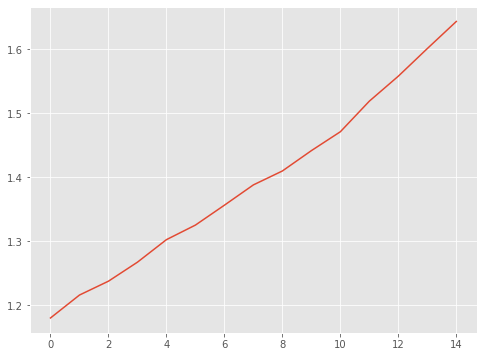

In [443]:
# here we check the binomial p-values vs. kappa
# seems like power depends of kappa (not that the p in the binomial P-values is the null ratio kappa, not actual proportion)
# -  the constants do not match; seems like mysterious 3 or 2/3 or e^-1
# Also, Pr ( -2 log(pval) > 2q log(T)) seems indp. of r !

kk = np.linspace(0.2, .8, 15)
#kk = np.ones(15) * .5


mm = []
mm1 = []
ss = []
ss1 = []
pp = []
acc = []
for kappa in kk:
    T = 100000
    n = 20 * T # n/T -> infty
    r = .6
    q = r + .3
    n1 = n * (1 - kappa)
    n2 = n * kappa
    n0 = 2 * n1 * n2 / (n1 + n2)
    delta = r * np.log(T) / n0 / 2

    lam0 = 2 / T # lam0 * T < const
    lam1 = (np.sqrt(lam0) + np.sqrt(delta)) ** 2

    X = poisson.rvs(lam0 * n1, size = T)
    Y = poisson.rvs(lam1 * n2, size = T)

    W1 = np.sqrt(4 * (1 - kappa) * Y) - np.sqrt(4 * kappa * X)
    
    p = kappa
    pvals = binom_test(Y, X + Y, p, randomize=True, alternative='greater')

    W = np.sqrt(- 2 * np.log(pvals))
    std = np.std( W )
    mean = np.mean( W )
    mean1 = np.mean( W1)
    std1 = np.std( W1 )
    prob = np.mean( W**2 > 2*q * np.log(T) )
    
    mm += [mean]
    mm1 += [mean1]
    ss1 += [std1]
    ss += [std]
    pp += [- np.log(prob) / np.log(T)]

    # W^2 = -2 log(p) ~ (s Z + m)**2
    # W ~ (s Z + m)
    # 
    #mean(W) ~ mu
    #std(W) ~ sigma
        
a = np.sqrt(r * np.log(T) / 2) 
b = 1
plt.plot(kk, np.array(mm) / a)
plt.plot(kk, np.array(mm1) / a)
plt.plot(kk, np.array(ss) / b )
plt.legend(['mean', 'mean-VS', 'std', 'std-VS'])
plt.show()

rho = ( (np.sqrt(q) - np.sqrt( r / 2 )) ) ** 2
plt.plot(pp / rho )
plt.show()

In [79]:
T = 10000
N1 = 3 * T
N2 = 3 * T
kappa = N2 / (N1 + N2)

r = 0.1
lam0 = 2 / T
tt = np.arange(T)

nMonte = 10000

delta = 0.4

q = (np.sqrt(r) + np.sqrt( delta )) ** 2

ls = 0
ls_z = 0
for _ in tqdm(range(nMonte)):
    O1, O2 = sample_perturbed2(T, N1, N2, lam0, r)
    pval = multi_pvals(np.array([N1, N1 - O1]), np.array([N2, N2 - O2]), randomize=True)
    z = np.sqrt(4 * O2 * (1 - kappa) + 3/8 ) - np.sqrt(4 * O1 * kappa + 3/8)
    pval_z = norm.sf(z)
    ls += -2 * np.log(pval) > 2 * q * np.log(T)
    ls_z += -2 * np.log(pval_z) > 2 * q * np.log(T)

a = - np.log(np.mean(ls / nMonte)) / np.log(T)
a_z = - np.log(np.mean(ls_z / nMonte)) / np.log(T)

sig = np.sqrt( 4 * kappa * (1 - kappa) )
rho = r * 2 * kappa * (1 - kappa)
a_th = ((np.sqrt(q) - np.sqrt(rho))) ** 2 / sig**2

print("emp = ", a)
print("emp_z = ", a_z)
print("ratio z = ", a / a_z)
print("")
print("th = ", a_th)
print("ratio th = ", a / a_th)

100%|██████████| 10000/10000 [00:04<00:00, 2171.16it/s]

emp =  0.5387254899964357
emp_z =  0.486730389129145
ratio z =  1.1068252610245273

th =  0.5257359312880715
ratio th =  1.0247073824239847


In [533]:
print("emp = ", a)
print("emp_z = ", a_z)
print("th = ", a_th)
print("ratio = ", a / a_th)

emp =  0.37269936941722426
emp_z =  0.3768099027432906
th =  0.251471862576143
ratio =  1.4820718532848773


In [499]:
sig = np.sqrt(4 * kappa * (1-kappa)) 
rho =  np.sqrt(2) * 2 * kappa * (1-kappa) * r 
a_th = ((np.sqrt(q) - np.sqrt(rho))) ** 2 / sig**2
a_th

0.26666666666666666

In [167]:
1534 * 2

3068

In [411]:
kappa = N2 / (N1 + N2)
sig = np.sqrt(4 * kappa * (1-kappa)) 
rho = 2 * kappa * (1-kappa) * r 
a_th = ((np.maximum(0, np.sqrt(q) - np.sqrt(rho)))) ** 2 / sig**2

print("emp = ", a)
print("emp_z = ", a_z)
print("th = ", a_th)


emp =  0.003620591928070305
emp_z =  0.0033832967989398627
th =  0.11333997346592446


In [401]:
rho

0.08838834764831843

In [317]:
a1 = []
a2 = []

for _ in range(10000):
    Nt1, Nt2 = sample_perturbed(T, N1, N2, lam0, r)
    pval = multi_pvals(np.array([Nt1, 0]).T, np.array([Nt2, 0]).T, randomize=True)
    O1 = N1 - Nt1
    O2 = N2 - Nt2

    a1 += [ O1 / (1 - kappa) ]
    a2 += [ O2 / (kappa) ]

In [326]:
2 * (N2 * N1) / (N1 + N2) * lam0

1.5999999999999999

0.31942380328141806
0.2909073194519745


In [101]:
- np.log(np.mean(ls)) / np.log(T)

0.3201464600743516

In [95]:
kappa = N2 / (N1 + N2)
sig = np.sqrt(4 * kappa * (1-kappa)) 
rho = 2 * kappa * (1-kappa) * r
a_th = ((np.sqrt(q) - np.sqrt(rho))/sig) ** 2

print(a_th)

0.2333920216900384


In [94]:
sig

1.0

## Sample once:

          berk_jones_greater  berk_jones_less  fisher_greater  fisher_less  \
null_95q            6.814281         6.741345        2.104427     2.107693   
observed                 NaN              NaN             NaN          NaN   
is_sig              0.000000         0.000000        0.000000     0.000000   

          hc_greater   hc_less  log_rank_greater  log_rank_less  \
null_95q    4.780447  4.677201          1.053348       1.053348   
observed         NaN       NaN               NaN            NaN   
is_sig      0.000000  0.000000          0.000000       0.000000   

          min_p_greater  min_p_less  ...  wilcoxon_less       T       N1  \
null_95q       9.885502    9.832559  ...       2.136037  1000.0  10000.0   
observed            NaN         NaN  ...            NaN     NaN      NaN   
is_sig         0.000000    0.000000  ...       0.000000     0.0      0.0   

               N2  Logrank        HC    Fisher       minP        BJ  wilcoxon  
null_95q  10000.0      NaN       

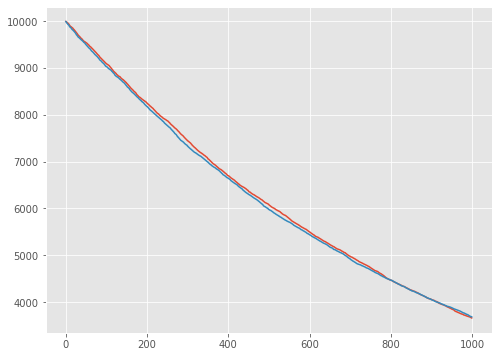

In [92]:
# single experiment non-null

T = 1000
N1 = N2 = 10000
beta = .7         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
r = .5
N0 = 2 * N1 * N2 / (N1 + N2)

Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, r)

lr, lr_pval = log_rank_test(Nt1, Nt2)
pvals = multi_pvals(Nt1, Nt2, randomize=True)
mt = MultiTest(pvals, stbl=False)

df_null = pd.read_csv(f"under_null_T{T}_N1_{N1}_N2_{N2}.csv").drop('Unnamed: 0', axis=1)
r = {'Logrank': np.abs(lr),
'HC': mt.hc()[0],
'Fisher': mt.fisher(),
'minP': mt.minp(),
'BJ': mt.berk_jones(gamma=.45),
'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue)
    }

df_null['obs'] = 'null_95q'
rr = df_null.set_index('obs').append(pd.DataFrame(r, index=['observed']))
s = (rr.T['null_95q'] < rr.T['observed'])
s.name = 'is_sig'
print(rr.append(s))

print("-------------------------------------------------------------\n")
print("Fliping roles of the lists:")
lr, lr_pval = log_rank_test(Nt2, Nt1)

pvals = multi_pvals(Nt2, Nt1)
mt = MultiTest(pvals, stbl=False)

r = {'Logrank': np.abs(lr),
'HC': mt.hc()[0],
'Fisher': mt.fisher(),
'minP': mt.minp(),
'BJ': mt.berk_jones(gamma=.45),
'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue)
    }

df_null['obs'] = 'null_95q'
rr = df_null.set_index('obs').append(pd.DataFrame(r, index=['observed']))
s = (rr.T['null_95q'] < rr.T['observed'])
s.name = 'is_sig'
print(rr.append(s))

tt = np.arange(T)
plt.plot(tt, Nt1[1:])
plt.plot(tt, Nt2[1:])
plt.show()
#pd.DataFrame({'N1' : Nt1, 'N2' : Nt2}).to_csv(f'surv_mu{mu}_eps{eps}.csv')


## Atomic experiment:

In [130]:
from survival import evaluate_test_stats, simulate_null

In [124]:
T = 1000
N1 = N2 = 2000

beta = .75         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
r = .5        # signal strength
nMonte = 10

lam0 = np.ones(T) / T * np.log(T)

res = pd.DataFrame()

for i in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0, eps, r)
    res1 = evaluate_test_stats(Nt1, Nt2,  randomized=True, alternative='both')
    res = res.append(res1, ignore_index=True)
    
res.agg(['mean', 'std'])

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: evaluate_test_stats() missing 2 required positional arguments: 'Ot1' and 'Ot2'

## Many experiments

In [84]:
def evaluate(itr, T, N, beta, r):
    """
    evalaute an atomic experiment
    """
    mu = 2 * r * np.log(T) / T
    eps = T ** (-beta)
    N1 = N2 = N

    Nt1, Nt2 = sample_survival_data(int(T), int(N1), int(N2), eps, mu)
    res = evaluate_test_stats(Nt1, Nt2, randomized=True, alternative='both')
    return res


### Null Behavior

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [23]:
# theoretic asymptotic values of HC

alpha = 0.01
Q95 = -np.log( - np.log(1 - alpha) / 2 )

for T in [100, 500, 1000, 10000]:
    
    b = np.sqrt(2 * np.log(np.log(T)))
    c =  2 * np.log(np.log(T)) + .5 * np.log( np.log( np.log ( T))) - 0.5 * np.log(4 * np.pi)
    crit = (Q95 + c) / b
    print(f"T = {T}, HC", crit)
    

T = 100, HC 4.173467718335046
T = 500, HC 4.176264724855984
T = 1000, HC 4.182287124106553
T = 10000, HC 4.2079080704500536


In [4]:
def quantile(x, q):
    """
    Compute the q-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, q)

def q95(x):
    return quantile(x, .95)

def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

    
def null_uniform_pvals(T, nMonte, stbl=True):
    df0 = pd.DataFrame()
    print("Simulating null...")
    for itr in tqdm(range(nMonte)):
        res = {}
        pvals = np.random.rand(T)

        mt = MultiTest(pvals, stbl=stbl)
        # if not using stbl=False, then sometimes
        # HC misses the significance of the strongest effect
        res['hc_greater'] = mt.hc()[0]
        res['fisher_greater'] = mt.fisher()
        res['min_p_greater'] = mt.minp()
        res['berk_jones_greater'] = mt.berk_jones(gamma=.45)
        df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0
    

def report_null_stats(df0, T, precision=5):
    dsp = df0.agg([q95, 'mean', 'std']).filter(
        ['log_rank_greater', 'hc_greater', 'x0', 'y0', 'lam1', 'lam2'])
    dsp.loc['std_95'] = [std_95(df0[c]) for c in dsp]

    print(np.round(dsp, precision))

    if 'lam1' in dsp:
        m = (dsp.loc['mean', 'lam1'] + dsp.loc['mean', 'lam2']) / 2
        s = np.sqrt((dsp.loc['std', 'lam1'] ** 2 + dsp.loc['std', 'lam2'] ** 2) / 2)
        print("lam * T = ", np.round(m * T, precision))
        print("SE(lam*T) = ", np.round(s * T, precision))


In [161]:
# null uniform p-vals
stbl = False

for T in [100, 200, 1000, 2000, 10000]:    
    df0 = null_uniform_pvals(T, 10000, stbl=stbl)
    report_null_stats(df0, T)


  1%|          | 66/10000 [00:00<00:15, 657.00it/s]

Simulating null...


  1%|          | 92/10000 [00:00<00:10, 918.59it/s]

        hc_greater
q95        1.87903
mean       0.90861
std        0.65153
std_95     0.01226
Simulating null...


  1%|          | 79/10000 [00:00<00:12, 782.85it/s]

        hc_greater
q95        2.04897
mean       1.04531
std        0.64954
std_95     0.01321
Simulating null...


  1%|          | 69/10000 [00:00<00:14, 682.64it/s]

        hc_greater
q95        2.36117
mean       1.27006
std        0.64510
std_95     0.01685
Simulating null...


  0%|          | 24/10000 [00:00<00:43, 231.74it/s]

        hc_greater
q95        2.43404
mean       1.35553
std        0.64245
std_95     0.01689
Simulating null...


100%|██████████| 10000/10000 [00:42<00:00, 236.13it/s]

        hc_greater
q95        2.63666
mean       1.50809
std        0.64342
std_95     0.01786


In [5]:
def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

In [6]:
def simulate_null(T, N1, N2, lam0, nMonte, stbl=True):
    """
    Args:
    -----
    :N1:      Initial size of group 1
    :N2:      Initial size of group 2
    :T:       Total numebr of events
    :nMonte:  number of experiments to evaluate

    """

    df0 = pd.DataFrame()
    print("Simulating null...")
    for itr in tqdm(range(nMonte)):
        Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0, 0, 0)
        Ot1 = -np.diff(Nt1)
        Ot2 = -np.diff(Nt2)
        res = evaluate_test_stats(Nt1[:-1], Nt2[:-1], Ot1, Ot2, stbl=stbl, randomize=False)
        df0 = df0.append(res, ignore_index=True)

    # critical values under the null:
    return df0


In [20]:
# under null
from twosample import binom_test_two_sided
from multitest import MultiTest
from typing import List

#params:
T = 100     # number of event

N = N1 = N2 = 1500    # number in group 1 and 2 at t=0
lam0 = 0.5
stbl = False

nMonte = 10000  #   number of experiments to evaluate dist. under null

df0 = simulate_null(T, N1, N2, lam0 * np.ones(T) / T, nMonte, stbl=stbl)
# critical values under the null:
df0['T'] = T
df0['N1'] = N1
df0['N2'] = N2
df0.to_csv(f"under_null_{stbl}_T_{T}_N1_{N1}_N2_{N2}_l{lam0}.csv")

report_null_stats(df0, T)

  0%|          | 7/10000 [00:00<02:31, 65.93it/s]

Simulating null...


100%|██████████| 10000/10000 [01:49<00:00, 91.27it/s]


        log_rank_greater  hc_greater
q95              1.95303     2.39906
mean             0.80815     0.19063
std              0.60520     1.34191
std_95           0.01745     0.10838


In [11]:
stbl=False
df0 = pd.read_csv(f"under_null_{stbl}_T_{T}_N1_{N1}_N2_{N2}_l{lam0}.csv")
report_null_stats(df0, T)

        log_rank_greater  hc_greater
q95              1.96311     3.08828
mean             0.79568     0.62771
std              0.60383     1.52802
std_95           0.01715     0.05735


In [18]:
0.00138

0.00138

### Non-Null Behavior

In [17]:
# under non-null

from twosample import binom_test_two_sided
from multitest import MultiTest
from typing import List

def run_many_experiments(T, N1, N2, nMonte):
    # under non-null
    bb = np.linspace(.5, .9, 7)
    rr = np.sqrt(np.linspace(0.01, 1, 9))
    mm = 2 * rr * np.log(T) / N1

    df1 = pd.DataFrame()
    nMonte = 100       # number of experiments

    for itr in tqdm(range(nMonte)):
        for beta in bb:
            for mu in mm:
                eps = T ** -beta   # sparsity rate
                Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
                res1 = evaluate_test_stats(Nt1, Nt2)
                res2 = evaluate_test_stats(Nt2, Nt1)
                res = pd.DataFrame(res1, index=[0])
                res['mu'] = mu
                res['eps'] = eps
                res['beta'] = beta
                res['itr'] = itr
                res['T'] = T
                df1 = df1.append(res, ignore_index=True)
    return df1

df1 = run_many_experiments(T, N1, N2, nMonte)

100%|██████████| 100/100 [24:26<00:00, 14.67s/it]


In [25]:
df1['T'] = T
df1['N'] = N1
df1['N1'] = N1
df1['N2'] = N2

In how many cases both the reversed and original sides were significant?

In [89]:
df0['T'] = T
df0['N'] = N1
df0['N1'] = N1
df0['N2'] = N2

In [26]:

global_params = ['T', 'N1', 'N2']

print(df0.groupby(global_params).agg(q95))
tcrit = df0.groupby(global_params).agg(q95)

good_side = 'greater'
bad_side = 'less'

for c in df1.groupby(global_params):
    print(f"Analyzing the case (T, N1, N2) = {c[0]}")
    dfc = c[1]

    for tsn in tests:
        name_good = tsn + '_' + good_side
        name_bad = tsn + '_' + bad_side

        # we check rate when both sides succedds. These are not good outcomes
        two_side_succ = ( dfc[name_good] > tcrit[name_good].values[0] ) & ( dfc[name_bad] > tcrit[name_bad].values[0] )
        print(f"{tsn}: both sides detected in {np.mean(two_side_succ)} of cases")
        print("(you should be worried if this number is significantly larger than 0.05)")

                  berk_jones_greater  berk_jones_less  fisher_greater  \
T    N1    N2                                                           
1000 10000 10000            6.814281         6.741345        2.104427   

                  fisher_less  hc_greater   hc_less  log_rank_greater  \
T    N1    N2                                                           
1000 10000 10000     2.107693    4.780447  4.677201          1.053348   

                  log_rank_less  min_p_greater  min_p_less  wilcoxon_greater  \
T    N1    N2                                                                  
1000 10000 10000       1.053348       9.885502    9.832559          2.112928   

                  wilcoxon_less  
T    N1    N2                    
1000 10000 10000       2.136037  
Analyzing the case (T, N1, N2) = (1000, 10000, 10000)


NameError: name 'tests' is not defined

### Power Analysis:

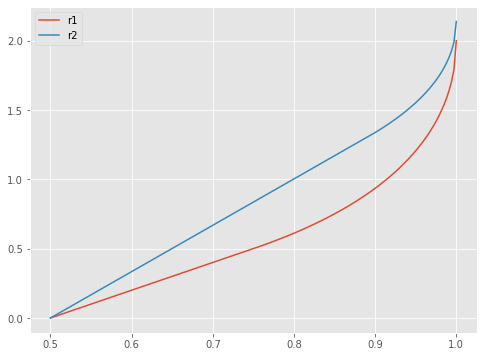

In [221]:
bb = np.linspace(0.5, 1, 171)

def rhos(be, sigma):
    if sigma**2 < 2:
        if be < 1 - sigma**2/4:
            return (2-sigma**2) * (be - 1/2)
        else:
            return (1-sigma*np.sqrt(1- be))**2
    else:
        if be < 1 - 1/sigma**2:
            return 0
        else:
            return (1-sigma*np.sqrt(1- be))**2

        
def plot_PT(r, sig):
    bb = np.linspace(0.5, 1, 171)
    rr = [rhos(b, sig) / r for b in bb]
    plt.plot(bb, rr)

            
kappa = 1/8

kappa_bar = 1 - kappa

r1 = 1 / 2
sig1 = 1

plot_PT(r1, sig1)

r2 = np.sqrt(2 * kappa * kappa_bar)
sig2 = np.sqrt(4 * kappa * kappa_bar)

plot_PT(r2, sig2)

plt.legend(['r1', 'r2'])
plt.show()